In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import PIL.ImageOps    
import cv2
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as functional
from PIL import Image

In [12]:
class SiameseNetworkDataset(Dataset):
  def __init__(self,dataset,transformations=None):
    self.dataset = dataset
    self.transform =  transformations

  def __getitem__(self,index):

    randomImage = random.choice(self.dataset.imgs)
    Image0 = Image.open(randomImage[0])
    probability = random.randint(0,1)
    
    new_random_image = random.choice(self.dataset.imgs) 
  
    if(probability):
      while(new_random_image[1]!=randomImage[1]):
        new_random_image = random.choice(self.dataset.imgs)
        
    else:
      while(new_random_image[1]==randomImage[1]):
        new_random_image = random.choice(self.dataset.imgs)

   
    Image0 = Image0.convert("L")
    Image1 = Image.open(new_random_image[0])
    Image1 = Image1.convert("L")

    if(self.transform!=None):
      Image0 = self.transform(Image0)
      Image1 = self.transform(Image1)

    return Image0,Image1,torch.from_numpy(np.array(int(randomImage[1]!=new_random_image[1]),dtype=np.float32))
      
  def __len__(self):
        return len(self.dataset.imgs)
        
          

In [13]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


In [14]:
transformations = transforms.Compose([transforms.Resize((100,100)),
                  transforms.ToTensor()])
folderDataset = datasets.ImageFolder(root = 'Train')
Siamese_DataSet = SiameseNetworkDataset(dataset=folderDataset,transformations=transformations)

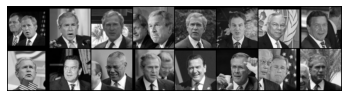

[0. 1. 1. 0. 1. 1. 1. 1.]


In [30]:
Visualize_Dataset = DataLoader(Siamese_DataSet,shuffle=True,batch_size=8)
sample_batch = next(iter(Visualize_Dataset))
Image_Concatenate = torch.cat((sample_batch[0],sample_batch[1]),0)
imshow(torchvision.utils.make_grid(Image_Concatenate))
print(sample_batch[2].numpy().reshape(-1))


In [15]:
class Build_Siamese_Network(nn.Module):
  def __init__(self):
    super(Build_Siamese_Network,self).__init__()
    self.cnn = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
    )

    self.connected = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,3)
    )

  def forward_once(self,input):
      output = self.cnn(input)
      output  = output.view(output.size()[0],-1)
      output = self.connected(output)
      return output

  def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

  

In [16]:
class ContrasiveLoss(nn.Module):
  def __init__(self,margin=2.0):
    super(ContrasiveLoss,self).__init__()
    self.margin = margin
  def forward(self,output1,output2,label):
    output = functional.pairwise_distance(output1,output2)
    loss =torch.mean((1-label)*(torch.pow(output,2)) + (label)*(torch.pow(torch.clamp(self.margin-output,min=0.0),2)))
    return loss
    
    

In [17]:
train_data_loader = DataLoader(Siamese_DataSet,shuffle=True,batch_size=24)

In [18]:
Siamese_model = Build_Siamese_Network()
Contrasive_loss = ContrasiveLoss()
optimizer = optim.Adam(Siamese_model.parameters(),lr=0.0005)

tensor([[[[0.2275, 0.2196, 0.2078,  ..., 0.0039, 0.0039, 0.0000],
          [0.3098, 0.2784, 0.2549,  ..., 0.0039, 0.0039, 0.0000],
          [0.4196, 0.3843, 0.3490,  ..., 0.0039, 0.0039, 0.0000],
          ...,
          [0.3725, 0.2157, 0.1804,  ..., 0.0078, 0.0000, 0.0000],
          [0.2431, 0.1882, 0.1765,  ..., 0.0078, 0.0000, 0.0000],
          [0.1804, 0.1882, 0.1843,  ..., 0.0078, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0824, 0.0941, 0.1098,  ..., 0.1373, 0.1294, 0.1255],
          [0.1529, 0.1020, 0.1020,  ..., 0.1373, 0.1294, 0.1294],
          [0.2784, 0.1176, 0.0980,  ..., 0.1373, 0.1333, 0.1333]]],


        [[[0.7608, 0.7686, 0.7804,  ..., 0.2980, 0.2941, 0.2902],
          [0.7412, 0.7608, 0.7765,  ..., 0.3059, 0.3098, 0.3176],
          [0.7098, 0.7412, 0.7686,  ..

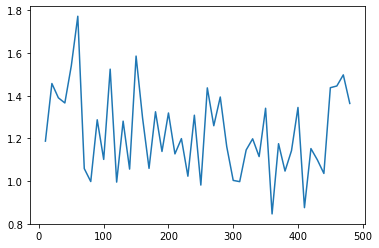

In [20]:
counter = []
loss_history = []
iteration_number= 0

for i in range(1):
  for j,(image1,image2,label) in enumerate(train_data_loader,0):
    
    optimizer.zero_grad()
    print(image1,image1.shape)
    embedding1,embedding2 = Siamese_model(image1,image2)
    loss = Contrasive_loss(embedding1,embedding2,label)
    print(loss)
    loss.backward()
    optimizer.step()
    if i % 10 == 0 :
            print(f"Epoch number {i}\n Current loss {loss.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss.item())
      
show_plot(counter, loss_history)
    
    
    


In [61]:
model = torch.jit.load("Siamese_model(1).pt")

NotImplementedError: Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::empty_strided' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMeta, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterCPU.cpp:31034 [kernel]
Meta: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterMeta.cpp:26824 [kernel]
QuantizedCPU: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterQuantizedCPU.cpp:929 [kernel]
BackendSelect: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterBackendSelect.cpp:726 [kernel]
Python: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:144 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\DynamicLayer.cpp:491 [backend fallback]
Functionalize: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\FunctionalizeFallbackKernel.cpp:280 [backend fallback]
Named: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ConjugateFallback.cpp:21 [kernel]
Negative: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\NegateFallback.cpp:23 [kernel]
ZeroTensor: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ZeroTensorFallback.cpp:90 [kernel]
ADInplaceOrView: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradOther: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradCPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradCUDA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradHIP: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradXLA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradMPS: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradIPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradXPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradHPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradVE: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradLazy: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradMeta: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradMTIA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradPrivateUse1: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradPrivateUse2: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradPrivateUse3: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
AutogradNestedTensor: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17484 [autograd kernel]
Tracer: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\TraceType_2.cpp:16726 [kernel]
AutocastCPU: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:487 [backend fallback]
AutocastCUDA: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:354 [backend fallback]
FuncTorchBatched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:815 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\LegacyBatchingRegistrations.cpp:1073 [backend fallback]
VmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:152 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\DynamicLayer.cpp:487 [backend fallback]
PythonDispatcher: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:148 [backend fallback]
